In [ ]:
''' 
Working on the pre-processing step!
All of the pre-process is now part of the renderClass!
'''

In [1]:
import open3d as o3d
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

import os
import torch
from pytorch3d.io import load_obj, save_obj, load_ply
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)

from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    FoVOrthographicCameras,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesVertex,
    TexturesAtlas,
    PointsRenderer,
    PointsRasterizationSettings,
    PointsRasterizer
)


# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:1")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

In [2]:
def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

## Methods for centering and normalize 3D mesh

In [7]:
mesh_path = "/home/andstasi/Projects/MediaVerse/3D_to_2D_converter/pytorch3d-renderer/data/random_example/45-interor-room-scene-obj/room obj.obj"
#mesh_path = "/home/andstasi/Projects/MediaVerse/3D_to_2D_converter/pytorch3d-renderer/data/random_example/home/casa.obj"

### Use Pytorch3D

In [8]:
def pre_processing_mesh(mesh_path):
    """
    Function for preprocessing (scaling and centering) the given mesh
    Args:
        mesh_path (str): The path of the OBJ mesh 

    Returns:
        [pytorch3d.structure]: The original mesh but ready for rendering (scaled and centered)
    """

    #get vertices, faces and aux from the obj file
    verts, faces, aux = load_obj(mesh_path)    
    
    faces_idx = faces.verts_idx.to(device) #get ids from the faces for back projecting
    verts = verts.to(device)

    # We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 
    # (scale, center) will be used to bring the predicted mesh to its original center and scale
    center = verts.mean(0)
    verts = verts - center
    scale = max(verts.abs().max(0)[0])
    verts = verts / scale

    # We construct a Meshes structure for the target mesh
    trg_mesh = Meshes(verts=[verts], faces=[faces_idx])

    return trg_mesh

In [9]:
trg_mesh = pre_processing_mesh(mesh_path)

/home/andstasi/anaconda3/envs/pytorch3d-renderer/lib/python3.8/site-packages/pytorch3d/io/obj_io.py:533: UserWarning: Mtl file does not exist: /home/andstasi/Projects/MediaVerse/3D_to_2D_converter/pytorch3d-renderer/data/random_example/45-interor-room-scene-obj/room obj.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


In [10]:
trg_mesh.verts_list()

[tensor([[ 0.2611,  0.2805, -0.2006],
         [ 0.2593,  0.2805, -0.2043],
         [ 0.2563,  0.2805, -0.2072],
         ...,
         [ 0.6877, -0.1739, -0.5264],
         [ 0.6906, -0.1719, -0.5208],
         [ 0.6877, -0.1719, -0.5264]], device='cuda:1')]

In [12]:
trg_mesh.verts_list()

tensor([[ 0.2611,  0.2805, -0.2006],
        [ 0.2593,  0.2805, -0.2043],
        [ 0.2563,  0.2805, -0.2072],
        ...,
        [ 0.6877, -0.1739, -0.5264],
        [ 0.6906, -0.1719, -0.5208],
        [ 0.6877, -0.1719, -0.5264]], device='cuda:1')

In [31]:
points = np.array(trg_mesh.verts_list()[0].cpu())


In [48]:
max_distance = []
for i in points:
    max_distance.append(np.sqrt(sum(i**2)))

In [50]:
max(max_distance)*0.8

1.1885055300239293

## Find max distance from the 0 axis

In [43]:
def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

In [1]:
def get_mesh(obj_filename, device):
    """
    Generates Meshes object and initializes the mesh with vertices, faces,
    and textures.

    Args:
        obj_filename: str, path to the 3D obj filename
        device: str, the torch device containing a device type ('cpu' or
        'cuda')

    Returns:
        mesh: Meshes object
    """
    # Get vertices, faces, and auxiliary information
    verts, faces, aux = load_obj(
        obj_filename,
        device=device,
        load_textures=True,
        create_texture_atlas=True,
        texture_atlas_size=4,
        texture_wrap="repeat"
         )
    
    
    # Create a textures object
    atlas = aux.texture_atlas
    # Create Meshes object
    mesh = Meshes(
        verts=[verts],
        faces=[faces.verts_idx],
        textures=TexturesAtlas(atlas=[atlas]),) 
    return mesh

### Open3D

In [9]:
mesh = o3d.io.read_triangle_mesh(mesh_path)

### Visualization of the results

In [10]:
def pc_new_norm(pcd):
    points = pcd.copy()
    centroid = np.mean(points, axis=0)
    points -= centroid
    furthest_distance = np.max(np.sqrt(np.sum(abs(points)**2,axis=-1)))
    points /= furthest_distance
    return points

In [11]:
scaled_vert = pc_new_norm(np.asarray(mesh.vertices))

In [19]:
scaled_vert.min(0)

array([-0.43725445, -0.77888154, -0.79952148])

In [15]:
def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    #points = sample_points_from_meshes(mesh, 5000)
    points = mesh
    #x, y, z = points.clone().detach().cpu().squeeze().unbind(1)
    x, y, z =  points[:,0],points[:,1],points[:,2]    
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

<ipython-input-15-e031bfb3f434>:8: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


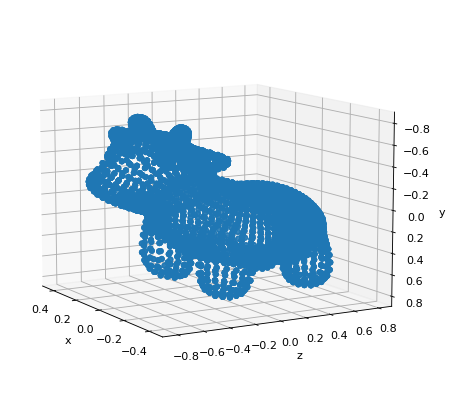

In [16]:
plot_pointcloud(scaled_vert, title="")

In [24]:
mesh_path = "/home/andstasi/Projects/MediaVerse/3D_to_2D_converter/pytorch3d-renderer/data/random_example/S3DIS_examples/S3DIS_examples.obj"
#mesh_path = "/home/andstasi/Projects/MediaVerse/3D_to_2D_converter/pytorch3d-renderer/data/random_example/car/uploads_files_2787791_Mercedes+Benz+GLS+580.obj"
verts, faces, aux = load_obj(mesh_path)  

In [28]:
verts, faces, aux = load_obj(
    mesh_path,
    device=device,
    create_texture_atlas=True,
    texture_atlas_size=4,
    texture_wrap="repeat"
        )

IndexError: index -1 is out of bounds for axis 0 with size 0